# <b/>1. Import Libararies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import device
from keras import backend
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D

2022-07-26 22:58:42.831136: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# <b/>2. Define Dice Coefficient & Loss

In [2]:
def dice_coef(y_true, y_pred):
    
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)

    intersection = backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + 1e-7)
def dice_coef_loss(y_true, y_pred):
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)

    intersection = backend.sum(y_true_f * y_pred_f)
    return 1-(2. * intersection + 1e-7) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + 1e-7)

# <b/>3. Data Load & Processing

In [3]:
# Load
x_train = np.load('x_train.npy')
x_val = np.load('x_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
print("\tTrain\t\t\tTest\nX\t{}\t{}\nY\t{}\t{}".format(x_train.shape, x_val.shape, y_train.shape, y_val.shape))

	Train			Test
X	(240, 256, 256, 1)	(27, 256, 256, 1)
Y	(240, 256, 256, 1)	(27, 256, 256, 1)


In [4]:
# Processing
## floating
x_train = np.float64(x_train)
x_val = np.float64(x_val)
y_train = np.float64(y_train)
y_val = np.float64(y_val)

## normalization
for i in range(x_train.shape[0]):
    x_train[i] -= x_train[i].min()
    x_train[i] /= x_train[i].max()

    y_train[i] -= y_train[i].min()
    y_train[i] /= y_train[i].max()

for i in range(x_val.shape[0]):
    x_val[i] -= x_val[i].min()
    x_val[i] /= x_val[i].max()

    y_val[i] -= y_val[i].min()
    y_val[i] /= y_val[i].max()

# <b/>4. Create Model

In [5]:
model = Sequential()
# Encoder
## 32x256x256
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=x_train[0].shape))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
## 64x128x128
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
## 128x64x64
model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

# Decoder
## 128x64x64
model.add(UpSampling2D(size=2))
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
## 64x128x128
model.add(UpSampling2D(size=2))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
## 32x256x256
model.add(UpSampling2D(size=2))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())

# Output
model.add(Conv2D(1,kernel_size=1, activation='sigmoid'))
model.compile(optimizer='adam', loss=[dice_coef_loss], metrics=[dice_coef])
model.summary(line_length=120)

Model: "sequential"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 conv2d (Conv2D)                                      (None, 256, 256, 32)                            320               
                                                                                                                        
 batch_normalization (BatchNormalization)             (None, 256, 256, 32)                            128               
                                                                                                                        
 conv2d_1 (Conv2D)                                    (None, 256, 256, 32)                            9248              
                                                                                                                        
 batch_norma

2022-07-26 23:03:02.942960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 23:03:03.803524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-07-26 23:03:03.804067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 2 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2022-07-26 23:03:03.804440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/r

 conv2d_10 (Conv2D)                                   (None, 256, 256, 32)                            18464             
                                                                                                                        
 batch_normalization_10 (BatchNormalization)          (None, 256, 256, 32)                            128               
                                                                                                                        
 conv2d_11 (Conv2D)                                   (None, 256, 256, 32)                            9248              
                                                                                                                        
 batch_normalization_11 (BatchNormalization)          (None, 256, 256, 32)                            128               
                                                                                                                        
 conv2d_12 (Conv2D)             

# <b/>5. Learning

In [6]:
epochs = 100
with device('/GPU:2'):
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        epochs=epochs, batch_size=8)

Epoch 1/100


2022-07-26 23:03:10.776155: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


30/30 [==============================] - 6s 69ms/step - loss: 0.3272 - dice_coef: 0.6728 - val_loss: 0.7424 - val_dice_coef: 0.2574
Epoch 2/100
30/30 [==============================] - 1s 44ms/step - loss: 0.1226 - dice_coef: 0.8774 - val_loss: 0.9664 - val_dice_coef: 0.0335
Epoch 3/100
30/30 [==============================] - 1s 45ms/step - loss: 0.0989 - dice_coef: 0.9011 - val_loss: 0.9924 - val_dice_coef: 0.0076
Epoch 4/100
30/30 [==============================] - 1s 45ms/step - loss: 0.0848 - dice_coef: 0.9152 - val_loss: 0.9923 - val_dice_coef: 0.0077
Epoch 5/100
30/30 [==============================] - 1s 45ms/step - loss: 0.0639 - dice_coef: 0.9361 - val_loss: 0.9980 - val_dice_coef: 0.0020
Epoch 6/100
30/30 [==============================] - 1s 44ms/step - loss: 0.0521 - dice_coef: 0.9479 - val_loss: 0.9970 - val_dice_coef: 0.0030
Epoch 7/100
30/30 [==============================] - 1s 44ms/step - loss: 0.0448 - dice_coef: 0.9552 - val_loss: 0.9976 - val_dice_coef: 0.0024
Epoc

# <b/>6. Show Result

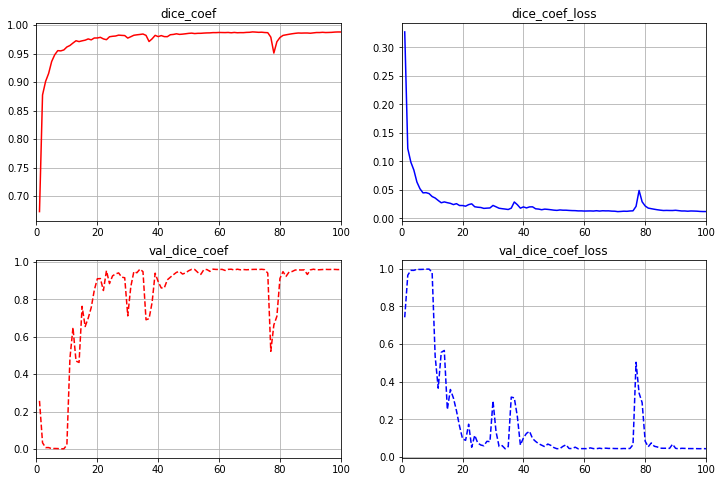

In [7]:
epochs = np.arange(100)+1
plt.figure(figsize=(12,8))
plt.subplot(2,2,1), plt.grid(), plt.plot(epochs, history.history['dice_coef'], 'r')
plt.xlim(0,epochs[-1]), plt.title('dice_coef')

plt.subplot(2,2,2), plt.grid(), plt.plot(epochs, history.history['loss'], 'b')
plt.xlim(0,epochs[-1]), plt.title('dice_coef_loss')

plt.subplot(2,2,3), plt.grid(), plt.plot(epochs, history.history['val_dice_coef'], 'r--')
plt.xlim(0,epochs[-1]), plt.title('val_dice_coef')

plt.subplot(2,2,4), plt.grid(), plt.plot(epochs, history.history['val_loss'], 'b--')
plt.xlim(0,epochs[-1]), plt.title('val_dice_coef_loss')

plt.show()

In [8]:
# Predict
pred = model.predict(x_train[:4])
pred.shape

2022-07-26 23:07:49.438470: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


1/1 [==============================] - 2s 2s/step


(4, 256, 256, 1)

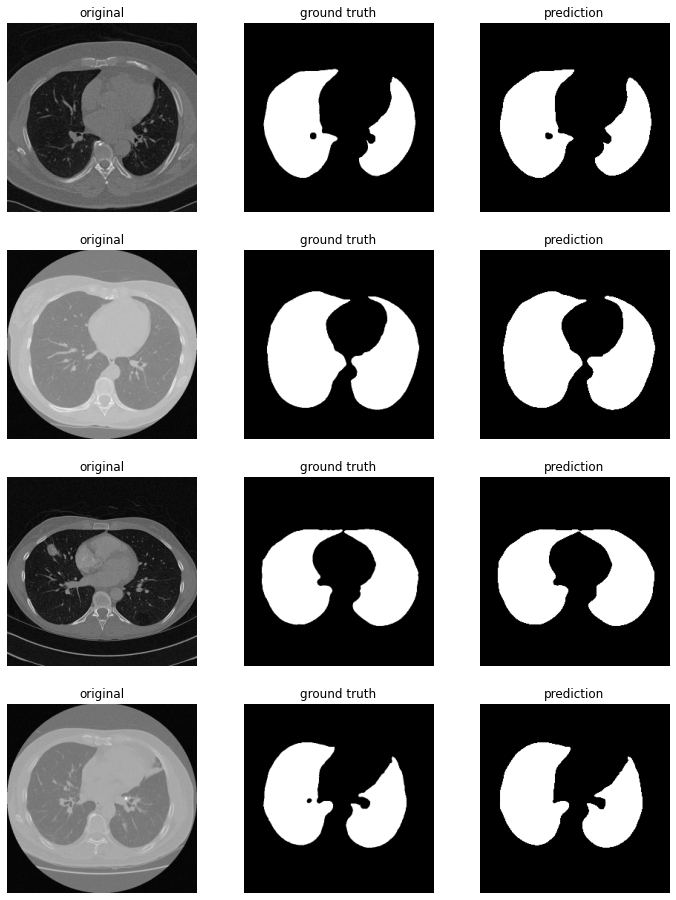

In [9]:
plt.figure(figsize=(12,16))
for i in range(4):
    plt.subplot(4,3,i*3+1), plt.axis('off'), plt.imshow(x_train[i], cmap='gray'), plt.title('original')
    plt.subplot(4,3,i*3+2), plt.axis('off'), plt.imshow(y_train[i], cmap='gray'), plt.title('ground truth')
    plt.subplot(4,3,i*3+3), plt.axis('off'), plt.imshow(pred[i], cmap='gray'), plt.title('prediction')
plt.show()